## Correlation Between Political Parties and Subsidy Allocation in South Holland

As a resident of the Province of South Holland, I am interested in exploring whether the coalition of certain political parties influences the allocation of subsidies. 

The Province of South Holland provides all its subsidy data as open data, which can be accessed here: [South Holland Subsidy Register](https://subsidieregister.zuid-holland.nl).

### Objective
With the assistance of ChatGPT, I aim to analyze whether spending patterns vary or can be correlated with the political party coalition currently in power.


### Author
Michael de Winter

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch 
import plotly.graph_objects as go
import os.path

In [2]:
# From ChatGTP with map the year to the political coalition party which was then in power
def map_parties(year):
    if year >= 2023:
        return "BBB, VVD, GroenLinks, D66, PvdA, PVV"
    elif year >= 2019:
        return "Forum for Democracy (FvD), VVD, CDA, GroenLinks, D66"
    elif year >= 2015:
        return "VVD, CDA, D66, SP"
    elif year >= 2011:
        return "VVD, CDA, D66, PVV"
    elif year >= 2007:
        return "CDA, VVD, PvdA"
    elif year >= 2003:
        return "CDA, VVD, D66"
    elif year >= 1999:
        return "CDA, VVD, D66"
    elif year >= 1995:
        return "CDA, VVD, D66"
    else:
        return "CDA, PvdA, VVD"
    
# Generalize the thema's of certain subsidies for normalization and comparison across year.
# Mostly let ChatGTP come up with these thema's with additional checking from me.   
def map_theme(category):
    """Determine the theme(s) for a given category using if statements."""
    themes = []

    if category in [
        '3.2 Verduurzaming gebouwde omgeving',       
        '3.1 Schone en duurzame elektriciteitsvoorziening',
        '3.3 Duurzaam energie-en grondstoffensysteem in de industrie'
    ]:
        themes.append('Duurzaamheid')

    if category in [
        '5.1 Gezonde natuur',
        '5.3 Leven met water',
        '7.1 Bevorderen verbetering milieukwaliteit en gezondheid',
        '7.3 Klimaatbestendig Zuid-Holland'
    ]:
        themes.append('Natuur & Milieu')

    if category in [
        '2.1 Snel van A naar B',
        '2.2 Beheer en onderhoud: op orde en duurzaam',
        '2.1 Duurzame en veilige bereikbaarheid voor iedereen',
        '2.3 Veilig en duurzaam'
    ]:
        themes.append('Mobiliteit')

    if category in [
        '4.3 Erfgoed, cultuur en toerisme',
        '4.2 Erfgoed en Cultuur'
    ]:
        themes.append('Cultuur & Erfgoed')

    if category in [
        '4.1 Innovatie: richting duurzaam en digitaal',
        '4.1 Toekomstbestendig economisch vestigingsklimaat',
        '4.2 Creëren van een rijk vestigingsklimaat'
    ]:
        themes.append('Economie & Innovatie')

    if category in [
        '5.2 Toekomstbestendige landbouw',
        '5.2 Transitie landbouw'
    ]:
        themes.append('Landbouw & Voedsel')

    if category in [
        '6.1 Voldoende juiste woningen op de juiste plek',
        '6.1 Wonen'
    ]:
        themes.append('Wonen')

    if category in [
        '1.1 Beter bestuur',
        '1.2 Sterke samenleving'
    ]:
        themes.append('Bestuur')

    if category in [
        "6.3 Afspraken met regio's",
        '6.2 Vitaliteit en kwaliteit in de leefomgeving'
    ]:
        themes.append('Regionale Ontwikkeling')

    if category in [
        '7.2 Bevorderen recreatie duurzame toerisme en sport',
        '7.2 Gezonde en bewegingsvriendelijke leefomgeving'
    ]:
        themes.append('Recreatie & Sport')

    return ", ".join(themes) if themes else "Onbekend Thema"

In [3]:
load_previous = True

In [4]:
# Fetch data from the API can be skipped if a parquet file is already found.
if os.path.exists("subsidie_data_pzh.parquet") and load_previous is True:

    results = pd.read_parquet("subsidie_data_pzh.parquet")

else:
    results = pd.DataFrame()    
    for xi in range(1,json.loads(requests.get("https://subsidieregister.zuid-holland.nl/api/subsidies").text)["paging"]['totaalnrofpages']):
        url = "https://subsidieregister.zuid-holland.nl/api/subsidies?pageno="+str(xi)  # Replace with the actual URL
        response = requests.get(url)

        # Print the response content
        print("Status Code:", response.status_code)
        print("Response Body:", response.text)
        data = json.loads(response.text)
        results = pd.concat([results,pd.DataFrame(data['results'])])

In [5]:
# Add the political coalition and a more generalized theme.
results['partijen'] = results.apply(lambda x: map_parties(x.jaar), axis=1)
results["Thema"] = results.apply(lambda x: map_theme(x.doelstellingnaam), axis=1)

In [6]:
# Group by based on parties, year and thema's for making bar charts
df =results.groupby(['partijen','jaar', 'Thema']).agg(
    total_subsidy=('verleendbedrag', 'sum'),
    number_of_subsidies=('verleendbedrag', 'count')
).reset_index()

In [7]:
df['Thema'].unique()

array(['Bestuur', 'Cultuur & Erfgoed', 'Duurzaamheid',
       'Economie & Innovatie', 'Landbouw & Voedsel', 'Mobiliteit',
       'Natuur & Milieu', 'Recreatie & Sport', 'Regionale Ontwikkeling',
       'Wonen'], dtype=object)

/var/folders/bn/flln7g490l75vv4q25m_pgfw0000gn/T/ipykernel_26697/3316975243.py:127: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


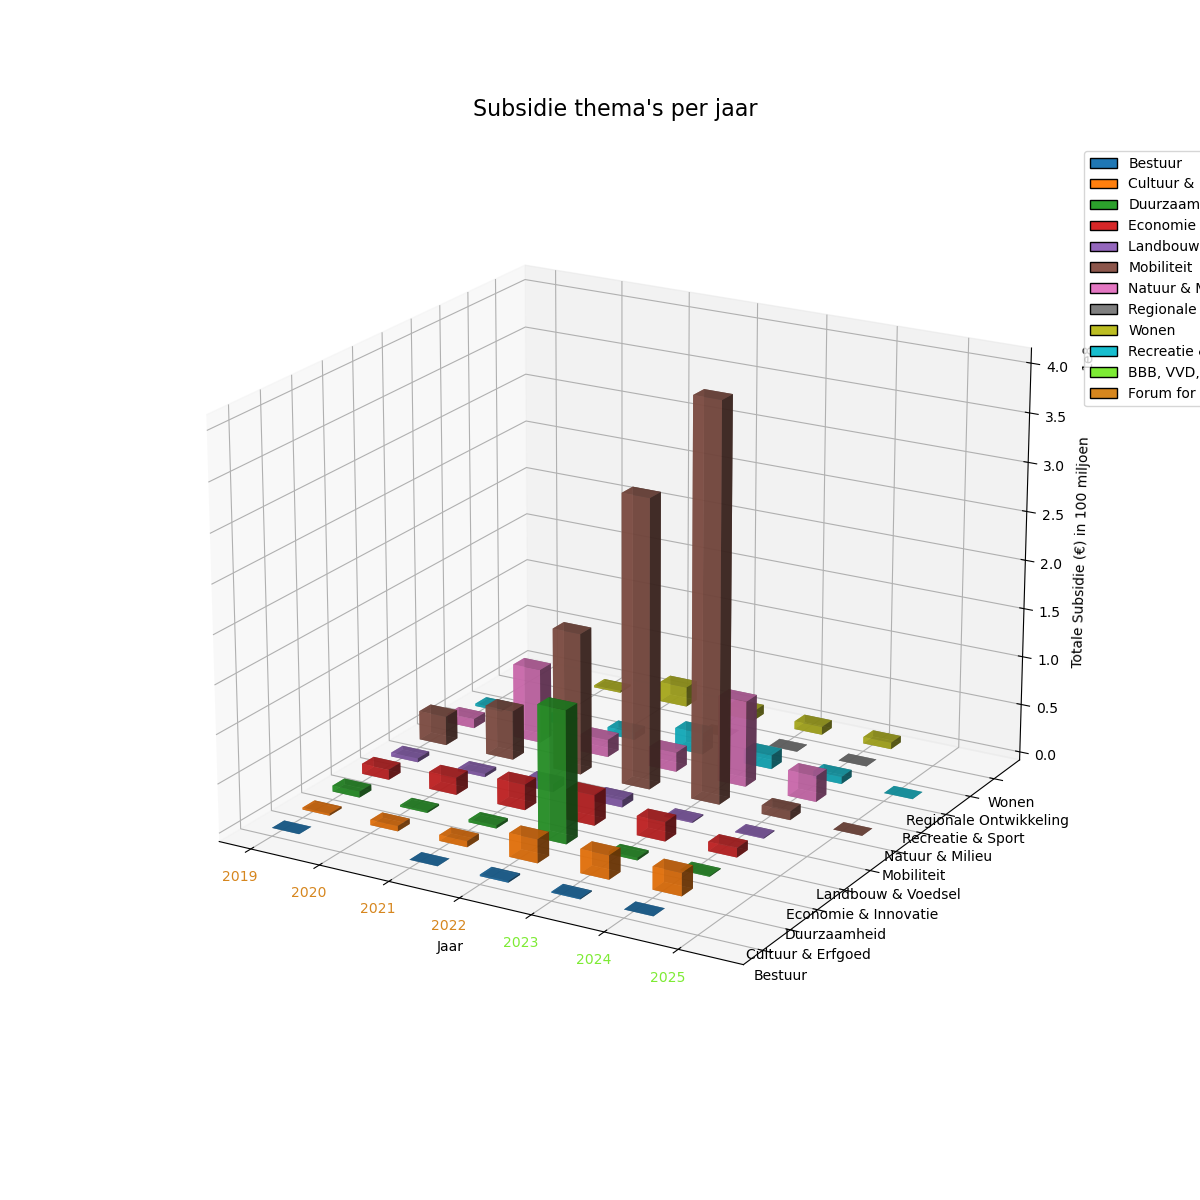

In [11]:
# Create a 3D bar chart with the colours of the years for which political coalition was in charge and
# x-axis: year which colour for political party, y-axis: the theme, z-axis: the total amount of granted subsidy.
%matplotlib widget
parties_colors = {
    "BBB, VVD, GroenLinks, D66, PvdA, PVV":  "#7deb34",
    "Forum for Democracy (FvD), VVD, CDA, GroenLinks, D66": "#d6861e",
}


theme_colors = {
    'Bestuur': '#1f77b4',
    'Cultuur & Erfgoed': '#ff7f0e',
    'Duurzaamheid': '#2ca02c',
    'Economie & Innovatie': '#d62728',
    'Landbouw & Voedsel': '#9467bd',
    'Mobiliteit': '#8c564b',
    'Natuur & Milieu': '#e377c2',
    'Regionale Ontwikkeling': '#7f7f7f',
    'Wonen': '#bcbd22',
    'Recreatie & Sport': '#17becf'
}

def get_theme_color(thema):
    """Return the color for a given Thema. Fallback to 'gray' if not in the dict."""
    return theme_colors.get(thema, 'gray')

# -----------------------------------------------------------
# 5) Convert jaar (X-axis) and Thema (Y-axis) to numeric idx
# -----------------------------------------------------------
unique_years = sorted(df['jaar'].unique())
unique_themas = sorted(df['Thema'].unique())

year_to_index = {year: i for i, year in enumerate(unique_years)}
thema_to_index = {thema: i for i, thema in enumerate(unique_themas)}

# -----------------------------------------------------------
# 6) Create 3D plot
# -----------------------------------------------------------
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

dx = 0.4
dy = 0.4

for _, row in df.iterrows():
    x_index = year_to_index[row['jaar']]
    y_index = thema_to_index[row['Thema']]
    
    z_lower = 0
    z_height = row['total_subsidy']
    
    color = get_theme_color(row['Thema'])
    
    ax.bar3d(
        x_index,  
        y_index,  
        z_lower,  
        dx,       
        dy,       
        z_height, 
        color=color,
        alpha=0.8
    )

# -----------------------------------------------------------
# 7) Add Legend for Thema Colors
# -----------------------------------------------------------
legend_patches = [
    Patch(facecolor=color, edgecolor='black', label=thema)
    for thema, color in theme_colors.items()
]


# If there's any Thema not in theme_colors, show 'Other':
if any(t not in theme_colors for t in df['Thema'].unique()):
    legend_patches.append(Patch(facecolor='gray', edgecolor='black', label='Other'))


party_legend_patches = [
    Patch(facecolor=c, edgecolor='black', label=p)
    for p, c in parties_colors.items()
]

legend_patches = legend_patches + party_legend_patches

ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.0, 1.0))

# -----------------------------------------------------------
# 8) X-axis: Each Jaar in a color based on its parties
# -----------------------------------------------------------
x_labels = [str(year) for year in unique_years]

ax.set_xticks(range(len(unique_years)))
ax.set_xticklabels(x_labels)

# Now color each x-tick label by the parties that apply to its year
for i, tick_label in enumerate(ax.get_xticklabels()):
    year = unique_years[i]
    # Figure out which parties are associated with this year
    party_str = map_parties(year)
    # Look up the color (or default to black if not found)
    color = parties_colors.get(party_str, "black")
    tick_label.set_color(color)

# (Optional) Add an extra legend for the parties color coding

#ax.legend(
#    handles=party_legend_patches,
#    title="Partijen (X-axis)",
#    loc='lower left',
#    bbox_to_anchor=(1.0, 0.6)
#)

# -----------------------------------------------------------
# 9) Y-axis & Z-axis formatting
# -----------------------------------------------------------
ax.set_title("Subsidie thema's per jaar", fontsize=16, pad=20)
ax.set_yticks(range(len(unique_themas)))
ax.set_yticklabels(unique_themas)
ax.set_ylabel('')
ax.set_zlabel('Totale Subsidie (€) in 100 miljoen')
ax.set_xlabel('Jaar')

# Adjust the viewing angle for clarity
ax.view_init(elev=20, azim=-60)

plt.tight_layout()
plt.show()

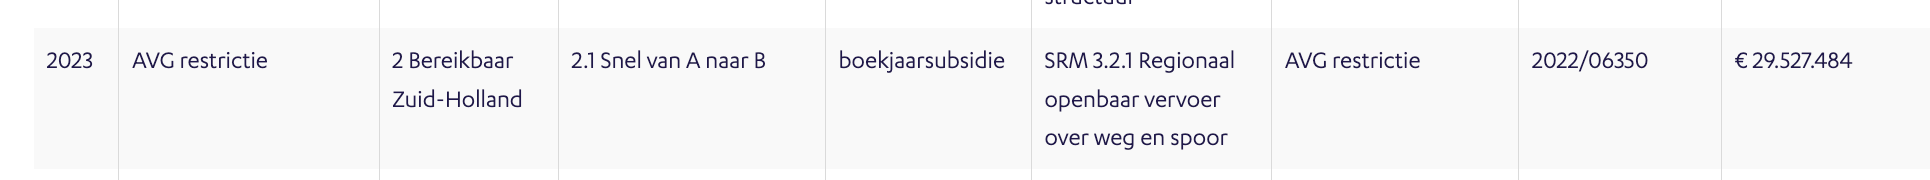